## Qualitative input-output relationship of our EMT network model

Note that this script reproduces our results shown in Figure 1 and Supplementary Fig. S2 (@ This code was written by Jonghoon Lee).

In [1]:
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(BoolNet))
suppressPackageStartupMessages(require(lhs))

### Functions

In [2]:
load_pert_conditions <- function(file.name) {
    # Read file
    condition_df <- read.table(file.name, sep='\t', header = TRUE, comment = '#', stringsAsFactors = FALSE)
    
    # Check that Min/Max are in the correct range([0, 1]) and Min < Max
    condition_df <- condition_df %>% mutate(valid_value = between(Min, 0, 1) & between(Max, 0, 1) & (Min <= Max))
    condition_df <- condition_df %>% group_by(Sim_ID) %>% group_modify(~{
        # Check 'Node' duplication
        unique_node <- !(.x$Node %in% .x$Node[duplicated(.x$Node)])
        .x %>% mutate(valid_value = valid_value, unique_node = unique_node)
    }) %>% ungroup
    
    is_valid <- condition_df %>% select(valid_value, unique_node) %>% unlist %>% all
    is_valid
    if(!is_valid) {
        print(condition_df)
        stop('Invalid simulation condition.')
    }
    
    condition_df %>% select(-valid_value, -unique_node)
}


generate_sim_conditions <- function(pert_conditions, n_samples = 100, rand.seed=12345) {
    if(is.numeric(rand.seed)) {set.seed(rand.seed)}
    sim_tb <- pert_conditions %>% group_by(Sim_ID) %>% group_modify(~{
        .x <- .x %>% mutate(Mult = Max - Min)
        rand_vals <- randomLHS(n_samples, length(.x$Node)) %>% round(digits = 3)
        condition_list <- lapply(seq(nrow(rand_vals)), function(x) {
            rand_vals[x,] * .x$Mult + .x$Min %>% set_names(.x$Node)
        })
        tibble(No = seq_along(condition_list), Condition = condition_list)
    })
    sim_tb %>% add_column(Sim_ID_Index = paste(.$Sim_ID, .$No, sep = '_'), .after = 'No') %>% select(-No)
}


run_helikar <- function(model, fix_nodes, fix_values, init_state = NULL, n_step=1000, win_size=300, rand.seed=12345) {
    if(is.numeric(rand.seed)) {set.seed(rand.seed)}
    if(is.null(init_state)) { init_state <- rep(0, length = length(model$genes))}
    if(length(init_state) != length(model$genes)) { stop('Invalid input : init_state') }
    if(n_step <= win_size) { stop('Invalid n_step / win_size') }

    # Initial state
    state <- init_state %>% set_names(model$genes)
    
    # Pre-run
    for(i in seq(n_step-win_size)) {
        state[fix_nodes] <- ifelse(runif(length(fix_values)) < fix_values, 1, 0)
        state <- BoolNet::stateTransition(model, state = state)
    }

    # Run
    res_mat <- matrix(NA, nrow = length(model$genes), ncol = win_size, dimnames = list(model$genes, seq(win_size)))
    for(i in seq(win_size)) {
        state[fix_nodes] <- ifelse(runif(length(fix_values)) < fix_values, 1, 0)
        state <- BoolNet::stateTransition(model, state = state)
        res_mat[,i] <- state
    }

    apply(res_mat, 1, mean)
}


run_helikar_all <- function(simul_conditions, init_state = NULL, n_step=1000, win_size=300, rand.seed=12345, N_cores = 10) {
    simul_res <- simul_conditions$Condition %>%
        mclapply(mc.cores = N_cores, function(x) {
            run_helikar(model, fix_nodes = names(x), fix_values = x, init_state = init_state, n_step=n_step, win_size=win_size, rand.seed=rand.seed)
        }) %>%
        set_names(simul_conditions$Sim_ID_Index) %>% bind_rows(.id = 'Sim_ID_Index') %>%
        pivot_longer(cols = 2:ncol(.), names_to = 'Node', values_to = 'Value') %>%
        left_join(simul_conditions, by = 'Sim_ID_Index') %>%
        mutate(Fix_Nodes = lapply(Condition, function(x) {names(x)})) %>%
        mutate(Fix_Values = lapply(Condition, function(x) {x})) %>%
        relocate(Sim_ID, .before = 'Sim_ID_Index') %>%
        relocate(Value, .after = 'Fix_Values') %>%
        relocate(Node, .after = 'Fix_Values') %>%
        select(-Condition)

    simul_res
}


plot_helikar <- function(data, sim_id, x_node, y_lim=NULL, fill.color="#F8A8FF", color="#FF2600", size=3, yaxis_name='Activity') {
    if(length(sim_id) != 1) { stop('invalid sim_id') }
    if(length(x_node) != 1) { stop('invalid x_node') }

    data <- data %>% filter(Sim_ID == sim_id)
    if(nrow(data) == 0) { stop('invalid sim_id') }

    data <- data %>%
        mutate(X_Node_Idx = sapply(Fix_Nodes, function(x) {which(x == x_node)})) %>%
        mutate(Fix_Node = unlist(map2(X_Node_Idx, Fix_Nodes, function(x,y) {y[x]}))) %>%
        mutate(Fix_Value = unlist(map2(X_Node_Idx, Fix_Values, function(x,y) {y[x]}))) %>%
        select(-Fix_Nodes, -Fix_Values, -X_Node_Idx)

    p <- data %>% ggplot(aes(Fix_Value, Value)) +
        geom_point(shape = 21, fill = fill.color, color = color, size = size) +
        facet_wrap(~Node, scales="free") +
        theme_bw() +
        ggtitle(paste0('Simulation_ID : ', sim_id)) +
        labs(x = x_node, y = yaxis_name, colour = '') +
        scale_x_continuous(limits = c(0, 1)) +
        theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            strip.background = element_blank(),
            panel.border = element_rect(colour = "black"))

    if(!is.null(y_lim)) {
        p <- p + scale_y_continuous(limits = y_lim)
    } else {
        p <- p + scale_y_continuous(limits = c(0, NA))
    }

    p
}


### Load files

In [3]:
# Load Boolean model
model_file <- './io_relationship/EMT_Network.txt'
model <- loadNetwork(model_file)

# Load simulation conditions
helikar_sim_file <- './io_relationship/EMT_simconditions.txt'
pert_conditions <- load_pert_conditions(helikar_sim_file)
pert_conditions %>% head(3)


Warning message in readLines(file, -1):
“incomplete final line found on './io_relationship/EMT_Network.txt'”


Sim_ID,Node,Min,Max,Alteration
<chr>,<chr>,<int>,<int>,<chr>
A549,TGFb,0,1,FIX
A549,RAS,1,1,FIX


### Generate simulation conditions

In [4]:
N_samples <- 1000

# Generate simulation conditions
simul_conditions <- generate_sim_conditions(pert_conditions, N_samples)
simul_conditions %>% head(3)

Sim_ID,Sim_ID_Index,Condition
<chr>,<chr>,<list>
A549,A549_1,"0.014, 1.000"
A549,A549_2,"0.448, 1.000"
A549,A549_3,"0.696, 1.000"


### Run simulation

In [5]:
N_cores <- 50

# Initial state
init_state <- rep(0, length=length(model$genes))

# Run simulation
simul_res <- run_helikar_all(simul_conditions, init_state = init_state, N_cores = N_cores)
simul_res %>% head(4)

Sim_ID,Sim_ID_Index,Fix_Nodes,Fix_Values,Node,Value
<chr>,<chr>,<list>,<list>,<chr>,<dbl>
A549,A549_1,"TGFb, RAS","0.014, 1.000",TGFb,0.006666667
A549,A549_1,"TGFb, RAS","0.014, 1.000",AKT,0.860000000
A549,A549_1,"TGFb, RAS","0.014, 1.000",AP1,0.290000000
A549,A549_1,"TGFb, RAS","0.014, 1.000",ERK,0.430000000


### Plot result

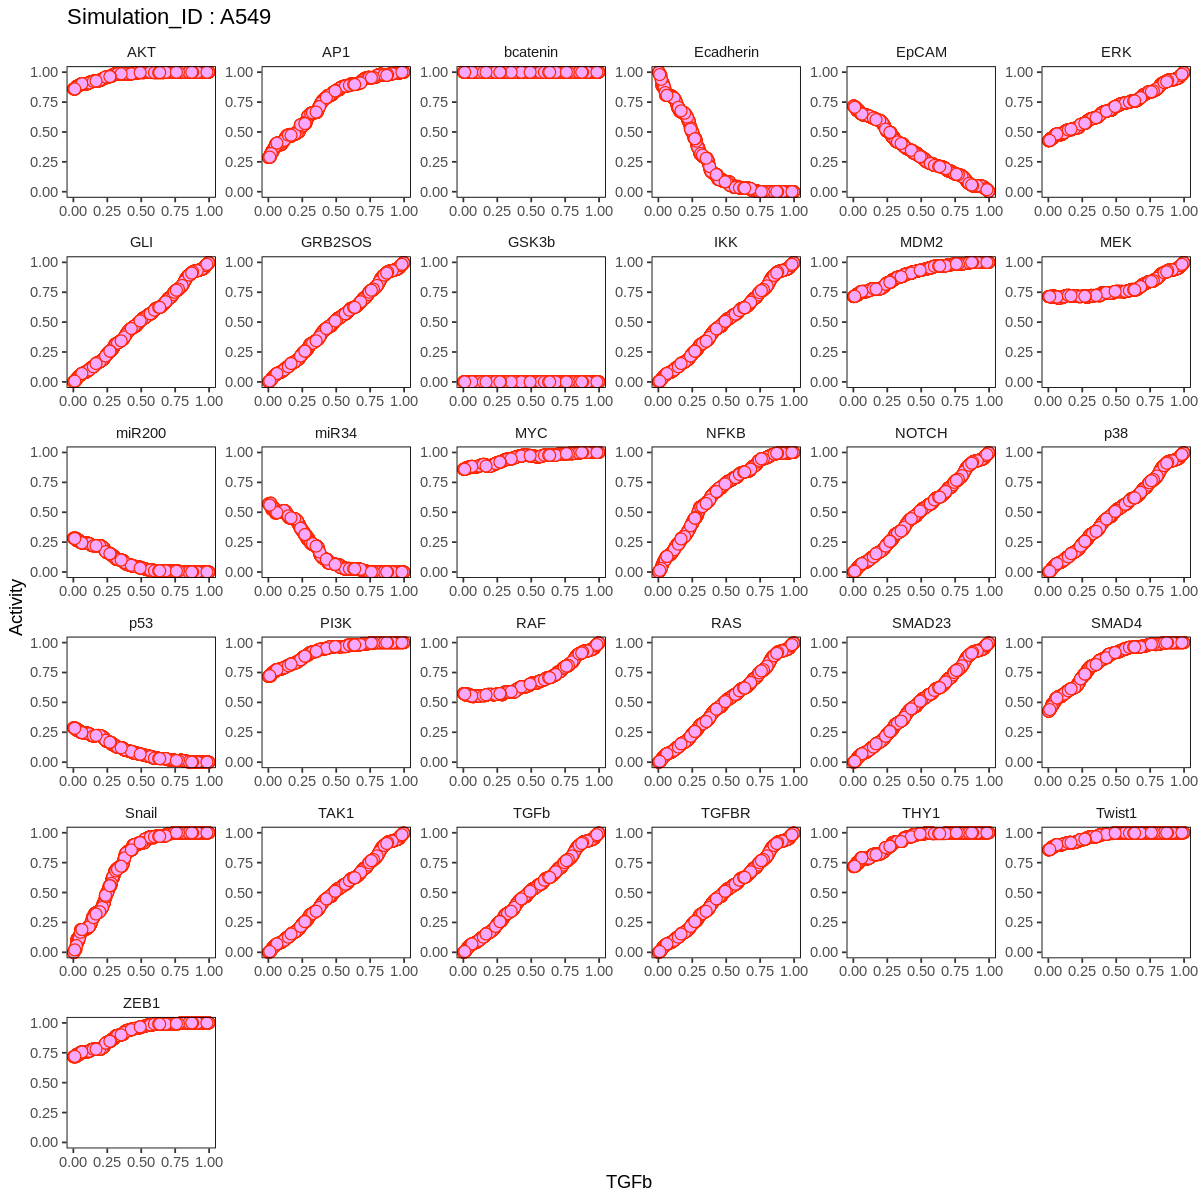

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot_helikar(data = simul_res, sim_id = 'A549', x_node = 'TGFb', y_lim=c(0,1), yaxis_name='Activity')